In [1]:
import pandas as pd
import sqlite3
import datetime
import os
import sys

In [2]:
ml_dir = os.path.join((os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))), 'findmytie_ml')
print(os.listdir(ml_dir))
sys.path.append(ml_dir)

['scraping', '.DS_Store', 'requirements.txt', 'scalable_instructions.txt', 'datasets', '.gitignore', 'output.png', 'scripts', 'color_grabber', 'venv', 'color_grabber_nn', 'semantic_segmentation']


In [3]:
from color_grabber.color_grabber_v_0_2 import grab_colors 
from semantic_segmentation.semantic_segmentation_v_0 import get_segmentation_mask

In [4]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [5]:
DB_PATH = '/Users/sdale/repos/findmytie/findmytie_backend/db.sqlite3' 
def get_table_names():
    conn = sqlite3.connect(DB_PATH)
    tables = conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    conn.close()
    return tables

TABLE_NAMES = {
    'listing': 'api_listing', 
    'search_query': 'api_searchquery',
    'query_match': 'api_querymatch',
}
def get_data():
    conn = sqlite3.connect(DB_PATH)
    df_dict = {}
    for table, table_key in TABLE_NAMES.items():
        query = f"SELECT * FROM {table_key}"
        df = pd.read_sql_query(query, conn)
        df_dict[table] = df
    conn.close()
    return df_dict

def put_data(df_dict: dict):
    conn = sqlite3.connect(DB_PATH)
    for table, df in df_dict.items():
        table_key = TABLE_NAMES[table]
        df.to_sql(table_key, conn, if_exists='replace', index=False)
    conn.close()

In [6]:
df_dict = get_data()

In [7]:
# remove all matches
put_data({'query_match': pd.DataFrame(columns=df_dict['query_match'].columns)})

In [8]:
ml_df = pd.read_csv('manual_listings.csv')

In [9]:
ml_df['image'] = ml_df['internal_image_path'].apply(lambda x: x.replace('media/', ''))
ml_df.drop(columns=['internal_image_path'], inplace=True)
ml_df['created_at'] = datetime.datetime.now()
ml_df['id'] = ml_df.index + 1
ml_df['colors'] = ''

In [10]:
ml_df.columns

Index(['title', 'solid_color', 'color_description', 'colors', 'price',
       'retailer_url', 'retailer_image_url', 'image', 'created_at', 'id'],
      dtype='object')

In [11]:
from tqdm import tqdm
import json
for df_i, row in tqdm(ml_df.iterrows(), total=len(ml_df)):
    path = os.path.join('/Users/sdale/repos/findmytie/findmytie_backend/media', row['image'])
    img = cv2.imread(path)
    if row['solid_color']:
        K = 1
        blur = True
    else:
        K = 6
        blur = False
    centroids, weights, center_points, intertia = grab_colors(
        img=img, 
        n_colors=K, 
        weights=(10, 100, 100, 1, 1), 
        resize=False, 
        blur=blur,
        remove_background=True,
        remove_dark_points=True, 
        dark_pct_thresh=5, 
        output_format='rgb',
        remove_grey_points=True,
        grey_pct_thresh=20,
        verbose=False,
    )
    sorted_inx = np.argsort(weights)[::-1]
    centroids = centroids[sorted_inx]
    weights = weights[sorted_inx]
    center_points = center_points[sorted_inx]
    color_data = []
    for i in range(len(weights)):
        color_data.append({
            'lab': cv2.cvtColor(np.uint8([[centroids[i]]]), cv2.COLOR_RGB2LAB)[0][0].tolist(),
            'rgb': centroids[i].tolist(),
            'weight': weights[i].tolist(),
        })
    ml_df.at[df_i, 'colors'] = json.dumps(color_data)

106it [00:16,  6.50it/s]


False
[{"lab": [231, 130, 122], "rgb": [227, 227, 239], "weight": 0.7315183823357644}, {"lab": [169, 149, 130], "rgb": [199, 148, 158], "weight": 0.08148591131439892}, {"lab": [159, 124, 148], "rgb": [157, 152, 115], "weight": 0.06650252059223405}, {"lab": [185, 127, 136], "rgb": [182, 178, 163], "weight": 0.06330213934973859}, {"lab": [102, 177, 147], "rgb": [169, 51, 66], "weight": 0.040039806201731476}, {"lab": [150, 144, 175], "rgb": [188, 129, 57], "weight": 0.017151240206132585}]


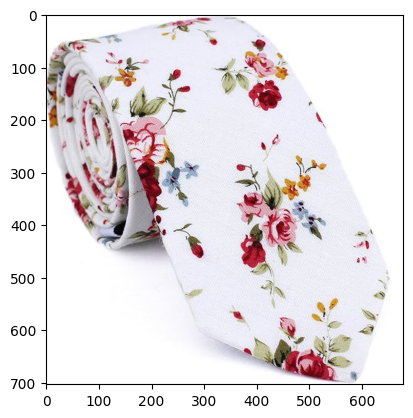

In [13]:
row = ml_df.iloc[-1]
print(row['solid_color'])
print(row['colors'])
img_path = os.path.join('/Users/sdale/repos/findmytie/findmytie_backend/media', row['image'])
assert(os.path.exists(img_path))
plt.imshow(plt.imread(img_path))

In [14]:
put_data({'listing': ml_df})